In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import numpy as np

In [2]:
seed = 32
np.random.seed(seed)
torch.manual_seed(seed)

# Dataset

In [3]:
train_data = datasets.CIFAR10(
    root="complete-data",
    train=True,
    download=True,
    transform=ToTensor()
)
#train_data[i] is a tuple(3*32*32, label) (C,H,W)
test_data = datasets.CIFAR10(
    root="complete-data",
    train=False,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
H=train_data[0][0].shape[1]
W=train_data[0][0].shape[2]

CAT_NUM=10
lr=0.001
batch_size=128
epochs=50

In [5]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# CNN model

In [6]:
class CNN(nn.Module):
    def __init__(self,H,W,cat_num):
        super().__init__()
        
        #self.convs=nn.ModuleList([nn.Conv2d(3,16,2,padding=1)]+[nn.Conv2d(i,i*2,3,padding=1) for i in [16,32，64]]) #128
        self.convs=nn.ModuleList([nn.Conv2d(3,32,2,padding=1)]+[nn.Conv2d(i,i*2,3,padding=1) for i in [32,64]])
        self.relu=nn.ReLU()
        self.maxpool=nn.MaxPool2d(2,2)
        self.flatten=nn.Flatten(1,-1)
        self.fc1=nn.Linear(int(128*H*W/(4**3)),256)
        #self.fc2=nn.Linear(256,64)
        self.fc3=nn.Linear(256,cat_num)
        self.dropout=nn.Dropout()
        
        
    def forward(self,x):#x is (batch,channel,H,W)
        for conv in self.convs:
            #print(x.shape)
            x=conv(x)
            
            x=self.relu(x)
            x=self.maxpool(x)
            x=self.dropout(x)
        x=self.flatten(x)
        x=self.dropout(x)
        x=self.relu(self.fc1(x))
        #x=self.relu(self.fc2(x))
        x=self.fc3(x)
        return x


# Training

In [7]:
def train_validation(epochs,train_dataloader,test_dataloader,optimizer,loss_function,model):
    train_losses=[]
    val_losses=[]
    model.to(device)
    for epoch in range(epochs):
        train_loss = 0.0
        val_loss=0.0
        model.train()
        for data in train_dataloader:
            
            #data=data.to(device)
            img,label=data
            img=img.to(device)
            label=label.to(device)
        

            optimizer.zero_grad()
            output = model(img)
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * img.size(0)
        
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(test_dataloader):
                img,label=data
                img=img.to(device)
                label=label.to(device)
                
                output=model(img)
                loss=loss_function(output,label)
                val_loss+=loss.item()*img.size(0)

        #average loss
        train_loss /= len(train_dataloader.dataset)
        val_loss /= len(test_dataloader.dataset)
        train_losses.append(train_loss)
        val_losses.append(val_loss)   
    print(train_losses)
    print(val_losses)     
    plt.semilogy(train_losses, label='Training Loss')
    plt.semilogy(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss curve')
    plt.legend()
    plt.show()



# Result

# Small dataset

In [10]:
from cifair import ciFAIR10
from torchvision import transforms
import numpy as np

train_small_data1=ciFAIR10("small-data", 'train0')
train_small_data2=ciFAIR10("small-data", 'train1')
train_small_data3=ciFAIR10("small-data", 'train2')
test_small_data1=ciFAIR10("small-data", 'val0')
test_small_data2=ciFAIR10("small-data", 'val1')
test_small_data3=ciFAIR10("small-data", 'val2')

'''class SmallDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image = torch.tensor(self.images[index], dtype=torch.float32).permute(2,0,1)
        label = torch.tensor(self.labels[index], dtype=torch.long)
        return image, label'''
# Define transformations for data augmentation
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(180)
])

# Define transformations for test data (no data augmentation)



class SmallDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image = torch.tensor(self.images[index], dtype=torch.float32).permute(2, 0, 1)
        label = torch.tensor(self.labels[index], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [11]:
images_train=np.concatenate((train_small_data1.data,train_small_data2.data,train_small_data3.data),axis=0)
labels_train=np.concatenate((train_small_data1.targets,train_small_data2.targets,train_small_data3.targets),axis=0)
print(labels_train.shape)
train_data=SmallDataset(images_train,labels_train)
print(train_data.images.shape)
train_data_augmented=SmallDataset(images_train,labels_train,train_transform)
#train_data_crop=SmallDataset(train_small_data.data,train_small_data.targets,transform=transforms.RandomCrop(32, padding=4))
#train_data_flip1=SmallDataset(train_small_data.data,train_small_data.targets,transform=transforms.RandomHorizontalFlip())
#train_data_flip2=SmallDataset(train_small_data.data,train_small_data.targets,transform=transforms.RandomVerticalFlip())
#train_data_rotate=SmallDataset(train_small_data.data,train_small_data.targets,transform=transforms.RandomRotation(180))


train_data_combined=torch.utils.data.ConcatDataset([train_data, train_data_augmented])
images_test=np.concatenate((test_small_data1.data,test_small_data2.data,test_small_data3.data),axis=0)
labels_test=np.concatenate((test_small_data1.targets,test_small_data2.targets,test_small_data3.targets),axis=0)
test_data=SmallDataset(images_test,labels_test)
print(test_data.images.shape)

(900,)
(900, 32, 32, 3)
(600, 32, 32, 3)


In [12]:
batch_size = 64

train_dataloader_small = DataLoader(
    train_data, batch_size=batch_size, shuffle=True)
test_dataloader_small = DataLoader(
    test_data, batch_size=batch_size, shuffle=False)

# Transfer learning -- fine tune resnet

In [50]:

from torchvision.models import resnet18#, ResNet50_Weights

resnet = resnet18(pretrained=True)

# Freeze 
for param in resnet.parameters():
    param.requires_grad = False


num_features = resnet.fc.in_features # number of input features for the last layer

#add a layer
num_classes = 10  
resnet.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(256, num_classes)
)
#resnet.fc=nn.Linear(in_features=num_features, out_features=num_classes, bias=True)
print(resnet)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Results

## Fine tune on full dataset

In [25]:
lr=0.00001
epochs=50
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(resnet.parameters(),lr)

[2.5155045153808593, 2.3943749503326415, 2.310993098602295, 2.2383959675598146, 2.1767729244995118, 2.1240443917083742, 2.0778220385742188, 2.0363183359527586, 2.0035005016326903, 1.975294740562439, 1.9474647271347045, 1.9222756188964845, 1.9044303067016601, 1.88075147190094, 1.863351214027405, 1.8490285720443727, 1.83572117893219, 1.8210295372772216, 1.8103009280395508, 1.7980881658172607, 1.791218978881836, 1.7808904360580444, 1.7704844305038452, 1.7622719417572021, 1.7569019485473634, 1.7488453623199463, 1.740339107131958, 1.7334892868423462, 1.729211868057251, 1.7227260515594482, 1.715798851890564, 1.7126549452972413, 1.703908203125, 1.7009178094482422, 1.696032716178894, 1.691407646408081, 1.689010659828186, 1.684048842086792, 1.6806653283309936, 1.6774516440200806, 1.6749747037506104, 1.6693478311157226, 1.6641349631118774, 1.664865983314514, 1.6594969455337525, 1.6561018264770508, 1.6536179468536376, 1.6524998526382446, 1.6499368448638916, 1.6464763534164428]
[2.452806409454346,

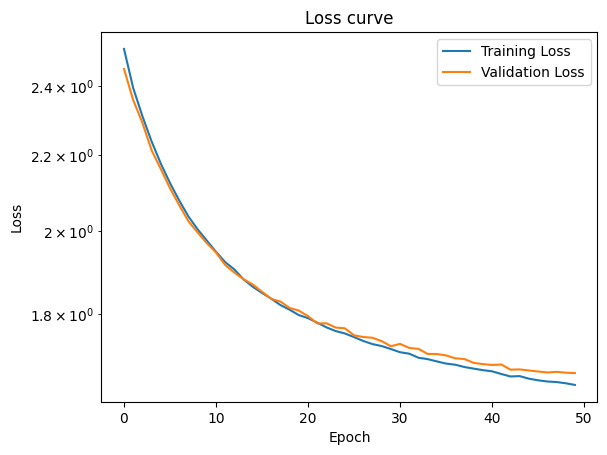

In [26]:
train_validation(epochs,train_dataloader,test_dataloader,optimizer,loss_fn,resnet)

## Fine tune on dataset with 300 training data and 200 testing data

In [25]:
lr=0.00001
epochs=1000
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(resnet.parameters(),lr)


[2.4517339346143934, 2.448279161453247, 2.4104008123609755, 2.4137543042500815, 2.3977220874362524, 2.4118380143907334, 2.3725080596076116, 2.3628389422098794, 2.382199843724569, 2.385223395029704, 2.3811849943796792, 2.354252842797173, 2.345740122265286, 2.3431432882944745, 2.347019148932563, 2.3381093576219345, 2.3328685061136882, 2.341088998582628, 2.3327070395151774, 2.3571908929612904, 2.298291704389784, 2.3016327317555745, 2.3262588119506837, 2.3055460177527536, 2.3003467644585505, 2.274847764439053, 2.297970282236735, 2.3078408474392362, 2.261992259555393, 2.310694466696845, 2.2962279997931585, 2.2857276323106555, 2.277696268293593, 2.2703008386823864, 2.2774677742852103, 2.2623589928944905, 2.2792648357815213, 2.2573252137502036, 2.2681682629055446, 2.240484823650784, 2.2478414471944173, 2.2489921241336397, 2.252276193830702, 2.2197180758582222, 2.2340133635203046, 2.2308065128326415, 2.2402345191107855, 2.2194408988952636, 2.2117538017696803, 2.2198840957217745, 2.218469492594

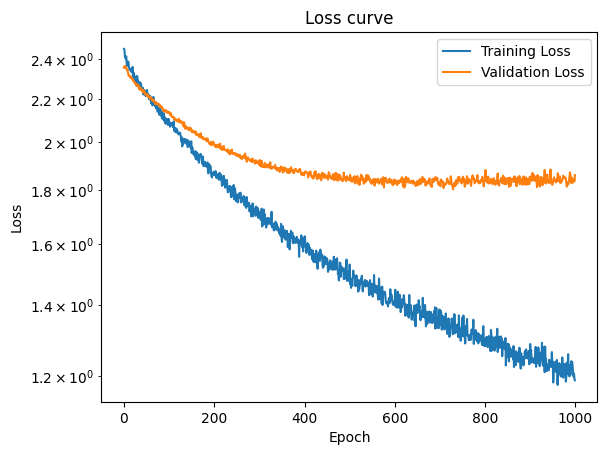

In [26]:
train_validation(epochs,train_dataloader_small,test_dataloader_small,optimizer,loss_fn,resnet)

## Fine tune on dataset with 5000 training data and 1000 testing data

In [46]:
# Select a subset of 5000 training images and 1000 test images
subset_train = list(range(0, len(train_data), 10))
subset_test=list(range(0, len(test_data), 10))
train_subset=torch.utils.data.Subset(train_data,subset_train)
test_subset=torch.utils.data.Subset(test_data,subset_test)
train_dataloader_small = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_dataloader_small = DataLoader(test_data, batch_size=batch_size, shuffle=True)

[2.4001907836914063, 2.366067830276489, 2.346506214141846, 2.329383694458008, 2.3156731811523437, 2.3116411388397218, 2.2944608688354493, 2.2830185905456544, 2.2763401290893555, 2.266269831085205, 2.255724702835083, 2.25058123626709, 2.2409581394195555, 2.2333575706481934, 2.2191456848144533, 2.2190263496398925, 2.213908368682861, 2.204985371017456, 2.199837719535828, 2.1833548789978026, 2.183207947731018, 2.1694497470855714, 2.17475758934021, 2.165466321563721, 2.1550153396606446, 2.145081386566162, 2.1480318572998045, 2.1386341312408446, 2.120700132369995, 2.1231278060913086, 2.1255796546936034, 2.1128089309692384, 2.1053686416625976, 2.092030215072632, 2.1014087669372556, 2.0871541416168213, 2.081768642807007, 2.083348991394043, 2.0566245189666748, 2.064668870925903, 2.0589074417114257, 2.057150062561035, 2.0432385864257814, 2.0412391723632815, 2.032801717376709, 2.0349821895599365, 2.0159193756103515, 2.0184651542663574, 2.016891841125488, 2.004085270500183, 1.9956862091064453, 1.9

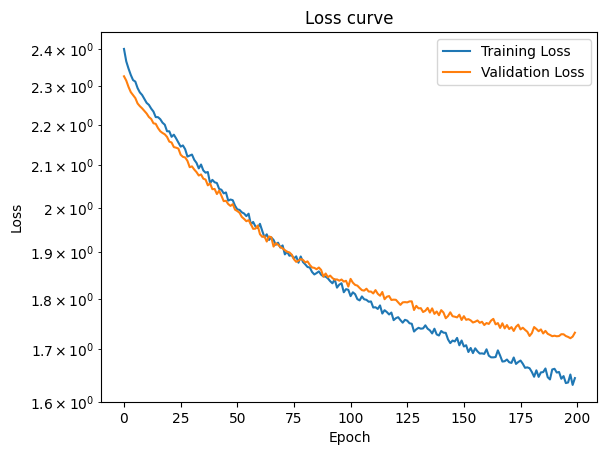

In [44]:
lr=0.00001
epochs=200
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(resnet.parameters(),lr)
train_validation(epochs,train_dataloader_small,test_dataloader_small,optimizer,loss_fn,resnet)

## Fine tune on dataset with 1000 training data and 500 testing data

In [47]:
# Select a subset of 1000 training images and 500 test images
subset_train = list(range(0, len(train_data), 50))
subset_test=list(range(0, len(test_data), 20))
train_subset=torch.utils.data.Subset(train_data,subset_train)
test_subset=torch.utils.data.Subset(test_data,subset_test)
print(len(train_subset))
print(len(test_subset))
train_dataloader_small = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_dataloader_small = DataLoader(test_data, batch_size=batch_size, shuffle=True)

1000
500


[2.4491708889007566, 2.423768976211548, 2.4127135181427004, 2.4252740478515626, 2.4160969772338867, 2.386119369506836, 2.3901511516571046, 2.386353649139404, 2.37361883354187, 2.360920166015625, 2.3679989223480225, 2.34702871131897, 2.3463244323730468, 2.348551845550537, 2.3415817756652832, 2.3171689548492433, 2.318541347503662, 2.324178985595703, 2.305657403945923, 2.310655336380005, 2.327359228134155, 2.299259075164795, 2.287072494506836, 2.2967529106140137, 2.2857456455230714, 2.300575357437134, 2.297895191192627, 2.2697390251159666, 2.2935694789886476, 2.2925172920227053, 2.2830948276519774, 2.2810056438446047, 2.2768073482513427, 2.2766669521331786, 2.2900276679992677, 2.2847889213562014, 2.2538300514221192, 2.249969442367554, 2.2576015701293946, 2.2337604751586912, 2.2478787746429445, 2.245601053237915, 2.2495893154144286, 2.247530963897705, 2.2267293548583984, 2.253027339935303, 2.230145498275757, 2.228785285949707, 2.2311783294677734, 2.2094344577789307, 2.2077108268737793, 2.1

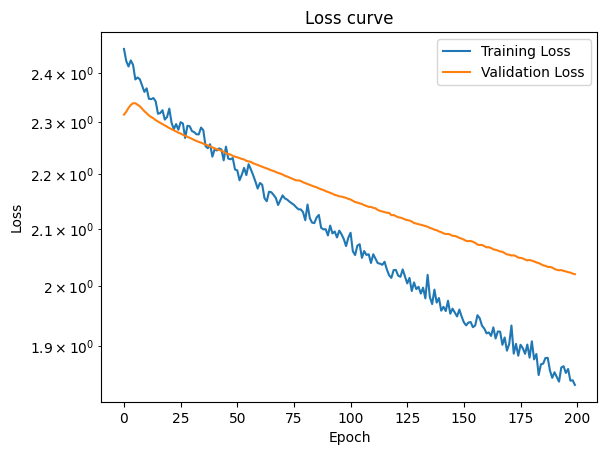

In [48]:
lr=0.00001
epochs=200
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(resnet.parameters(),lr)
train_validation(epochs,train_dataloader_small,test_dataloader_small,optimizer,loss_fn,resnet)

## Fine tune on dataset with 2000 training data and 1000 testing data

In [49]:
# Select a subset of 2000 training images and 1000 test images
subset_train = list(range(0, len(train_data), 25))
subset_test=list(range(0, len(test_data), 10))
train_subset=torch.utils.data.Subset(train_data,subset_train)
test_subset=torch.utils.data.Subset(test_data,subset_test)
print(len(train_subset))
print(len(test_subset))
train_dataloader_small = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_dataloader_small = DataLoader(test_data, batch_size=batch_size, shuffle=True)

2000
1000


[2.4397780723571776, 2.4049968662261962, 2.3986200046539308, 2.3919411602020264, 2.381837963104248, 2.3722883491516114, 2.3480204887390137, 2.3530103797912596, 2.3366641216278077, 2.3439476833343504, 2.3330711669921875, 2.3077141227722167, 2.317486598968506, 2.3173819580078123, 2.2935830059051514, 2.293442142486572, 2.2948431129455567, 2.2724504051208494, 2.2892299156188964, 2.271884407043457, 2.273701002120972, 2.2699678897857667, 2.252874834060669, 2.2467115898132324, 2.252231662750244, 2.2493928833007812, 2.2510585918426513, 2.2291092739105225, 2.2342442264556883, 2.2248455619812013, 2.220737924575806, 2.2222705402374268, 2.212081838607788, 2.2043881549835205, 2.1979982891082765, 2.1949085025787354, 2.1993768672943115, 2.1841960468292236, 2.1853796844482423, 2.1888865032196043, 2.1863302726745606, 2.1776564502716065, 2.1629765796661378, 2.17079976272583, 2.16840948677063, 2.16170659828186, 2.164928709030151, 2.144115827560425, 2.1410418128967286, 2.1304942417144774, 2.13686606025695

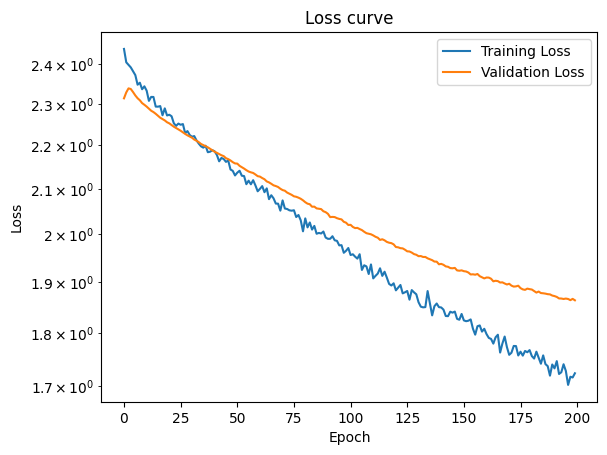

In [51]:
lr=0.00001
epochs=200
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(resnet.parameters(),lr)
train_validation(epochs,train_dataloader_small,test_dataloader_small,optimizer,loss_fn,resnet)

## Fine tune on dataset with 4000 training data and 1000 testing data

In [38]:
# Select a subset of 4000 training images and 1000 test images
subset_train = list(range(0, len(train_data), 12))
subset_test=list(range(0, len(test_data), 10))
train_subset=torch.utils.data.Subset(train_data,subset_train)
test_subset=torch.utils.data.Subset(test_data,subset_test)
print(len(train_subset))
print(len(test_subset))
train_dataloader_small = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_dataloader_small = DataLoader(test_data, batch_size=batch_size, shuffle=True)

4167
1000


[2.386116910329791, 2.367277537829475, 2.350058105371254, 2.3278736992651305, 2.328345330807984, 2.30603453293103, 2.2997108664992103, 2.294122330084504, 2.284267677172557, 2.2821580008805897, 2.2604754806451726, 2.2559993126308258, 2.2463606202061697, 2.2465768495508884, 2.2315253294255197, 2.2220628483563782, 2.2211649760600327, 2.208982270828734, 2.1946005676471847, 2.1904759375574723, 2.178077182810971, 2.1803484731421987, 2.169894836662426, 2.161614160787181, 2.154681449031441, 2.142443166295201, 2.151159930406556, 2.139325018549297, 2.1202353719386777, 2.1183097824250474, 2.107519392718907, 2.1101625679721927, 2.101550417951122, 2.102858049394073, 2.0913722780015735, 2.084650130703319, 2.080755397001559, 2.0754762776097664, 2.074336299685686, 2.0497360120209853, 2.048990118666636, 2.048684435437731, 2.0360432185799433, 2.0312850979383197, 2.0156463016444097, 2.0187083711319755, 2.0128540021783303, 2.0073796909777184, 2.002838099978369, 1.9974681696847156, 1.9913810216353498, 1.98

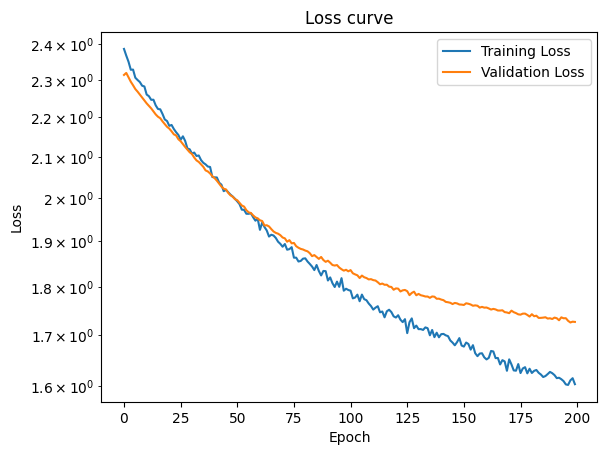

In [40]:
lr=0.00001
epochs=200
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(resnet.parameters(),lr)
train_validation(epochs,train_dataloader_small,test_dataloader_small,optimizer,loss_fn,resnet)